# Proyecto - Big Data

María Yorleni Alfaro Alfaro


# Datos de entrada


Se utilizará el conjunto de datos ya limpio y preprocesado en la fase anterior (preparado en el programa de Python "proyecto.py" que se encuentra en la misma carpeta de este Jupyter notebook). Esta información se encuentra almacenada en una tabla llamada "escuelas_ids" en base de datos.

Este conjunto de datos contiene una serie de características de las escuelas públicas y privadas en Costa Rica, en diferentes ámbitos como excelencia en la educación (cantidad de estudiantes aprobados, reprobados, repitentes, expulsiones, etc), problemas sociales (estudiantes que han abandonado la escuela, embarazos en estudiantes, casos atendidos por violencia, robos, destrucción de materiales, etc), infraestructura en las escuelas (cantidad de aulas, laboratorios, comedores, bibliotecas, sodas, computadoras, etc). Además de información del índice de desarrollo social para cada distrito donde se encuentra ubicada la escuela, segmentado por las siguientes dimensiones: índice de desarrollo social económico, participación, salud y educativo.

El objetivo de predicción es la variable <strong>"PromocionAlta"</strong> que indica "1" si la cantidad de estudiantes aprobados es mayor al 95% y "0" si la cantidad de estudiantes aprobados en menor o igual al 95%.







# Cargado de datos

In [124]:
# Carga el conjunto de datos completo, desde la tabla llamada "escuelas_ids" que se encuentra almacenada en base de datos. 
# Este paso no realiza ningún ajuste; simplemente lectura
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType,BooleanType)

from pyspark.sql import SparkSession

%config IPCompleter.greedy=True

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "escuelas_ids") \
    .load()


print ("Definición del esquema:")
df.printSchema()

print ("Datos cargados exitosamente:")
df.show()


Definición del esquema:
root
 |-- llave: integer (nullable = true)
 |-- nombre_ins: string (nullable = true)
 |-- creacion00: integer (nullable = true)
 |-- direg15: integer (nullable = true)
 |-- cdpr15: integer (nullable = true)
 |-- cdcan15: integer (nullable = true)
 |-- cddis15: integer (nullable = true)
 |-- regplan15: integer (nullable = true)
 |-- zona15: integer (nullable = true)
 |-- mit_15: integer (nullable = true)
 |-- mih_15: integer (nullable = true)
 |-- rt_15: integer (nullable = true)
 |-- rh_15: integer (nullable = true)
 |-- aprobt_15: integer (nullable = true)
 |-- aprobh_15: integer (nullable = true)
 |-- reprot_15: integer (nullable = true)
 |-- reproh_15: integer (nullable = true)
 |-- desa_15: integer (nullable = true)
 |-- desah_15: integer (nullable = true)
 |-- desert_15: integer (nullable = true)
 |-- deserh_15: integer (nullable = true)
 |-- act_15: integer (nullable = true)
 |-- ach_15: integer (nullable = true)
 |-- nst_15: integer (nullable = true)
 |--

In [125]:
# Se verifica que no existan columnas con valores nulos en el dataset a utilizar (este fue un trabajo de imputación que se 
# llevó a cabo en la fase anterior de preprocesamiento de datos, realizado en el programa de Python).

from pyspark.sql.functions import col


# Verifica que no haya quedado ninguna columna con valores nulos
cantidad_nulos = 0
for columna in columns_kept:
    selected_columns_df_null = selected_columns_df.where(col(columna).isNull())
    if selected_columns_df_null.count() != 0:
        cantidad_nulos = cantidad_nulos + selected_columns_df_null.count()
        print ("Existen valores nulos en la columna: ", columna)   

if  cantidad_nulos == 0:
    print ("No existe ninguna columna con valores nulos.")  


No existe ninguna columna con valores nulos.


# Selección de columnas de interés 

In [127]:
# Primero se seleccionan las columnas de interés que se considera aportan valor en relación a la variable de predicción 
# a utilizar: "PromocionAlta".
# Esto basado en el criterio experto luego de todo el trabajo de análisis de los datos. Dado que la mayoría de variables están 
# dadas tanto en cantidades totales como en cantidad de "hombres" (por ejemplo: cantidad de matriculados-cantidad de matriculados 
# hombres, cantidad de aprobados-cantidad de aprobados hombres, cantidad de reprobados-cantidad de reprobados hombres, etc) se 
# decide quitar todas las variables de hombres y trabajar solo con las que tienen los totales. De igual manera, para las variables
# que indican infraestructura (cantidad de aulas, laboratorios, comedores, bibliotecas, sodas, computadoras, etc) se tienen las
# variables para los totales y para los "buenos" (por ejemplo cantidad de aulas-cantidad de aulas buenas, laboratorios - laboratorios 
# buenos, etc) por lo tanto decide quitar todas las variables de "buenos" y trabajar solo con las que tienen los totales.

columns_kept = [ 
    'mit_15', 'rt_15', 'aprobt_15', 'reprot_15', 'desa_15', 'desert_15', 'act_15', 'nst_15', 'sit_15', 
    'embt_15', 'embmenor_15', 'embmayor_15', 'aat15', 'inft15', 'olat15', 'salt15', 'comt15', 'bibt15', 
    'gimt15', 'talt_ai15', 'otalt15', 'sodt15', 'indt15', 'lavt15', 'sant15', 'tvt15', 'vbt15', 'dvdt15', 
    'cetoi15', 'cetos15', 'cptoi15', 'cptos15', 'expto_15', 'expdef_15', 'exptem_15', 'agrve_15', 'agrvep_15', 
    'agrveo_15', 'agrfe_15', 'agrfep_15', 'agrfeo_15', 'agree_15', 'agreep_15', 'agreeo_15', 'agrre_15', 
    'agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 'agrdeo_15', 'agroe_15', 'agroep_15', 'agroeo_15', 
    'int_15', 'rit_15', 'frt_15', 'itt_15', 'extrant_15', 'PromocionAlta', 'Dimension_Economica', 'Dimension_Participacion', 
    'Dimension_Salud','Dimension_Educativa', 'IDS'  
    ]

selected_columns_df = df.select(columns_kept)

selected_columns_df.show()

+------+-----+---------+---------+-------+---------+------+------+------+-------+-----------+-----------+-----+------+------+------+------+------+------+---------+-------+------+------+------+------+-----+-----+------+-------+-------+-------+-------+--------+---------+---------+--------+---------+---------+--------+---------+---------+--------+---------+---------+--------+---------+---------+--------+---------+---------+--------+---------+---------+------+------+------+------+----------+-------------+-------------------+-----------------------+---------------+-------------------+-----+
|mit_15|rt_15|aprobt_15|reprot_15|desa_15|desert_15|act_15|nst_15|sit_15|embt_15|embmenor_15|embmayor_15|aat15|inft15|olat15|salt15|comt15|bibt15|gimt15|talt_ai15|otalt15|sodt15|indt15|lavt15|sant15|tvt15|vbt15|dvdt15|cetoi15|cetos15|cptoi15|cptos15|expto_15|expdef_15|exptem_15|agrve_15|agrvep_15|agrveo_15|agrfe_15|agrfep_15|agrfeo_15|agree_15|agreep_15|agreeo_15|agrre_15|agrrep_15|agrreo_15|agrde_15|agr

# Gráficos y estadísticas descriptivas previo al entrenamiento

## Estadísticas descriptivas

In [128]:
# Información descriptiva del dataframe.
selected_columns_df.describe(['mit_15', 'rt_15', 'aprobt_15', 'reprot_15', 'desa_15']).show()
selected_columns_df.describe(['desert_15', 'act_15', 'nst_15', 'sit_15', 'embt_15']).show()
selected_columns_df.describe(['embmenor_15', 'embmayor_15', 'aat15', 'inft15', 'olat15']).show()
selected_columns_df.describe(['salt15', 'comt15', 'bibt15','gimt15', 'talt_ai15']).show()
selected_columns_df.describe(['otalt15', 'sodt15', 'indt15', 'lavt15', 'sant15']).show()
selected_columns_df.describe(['tvt15', 'vbt15', 'dvdt15', 'cetoi15', 'cetos15']).show()
selected_columns_df.describe(['cptoi15', 'cptos15', 'expto_15', 'expdef_15', 'exptem_15']).show()
selected_columns_df.describe(['agrve_15', 'agrvep_15', 'agrveo_15', 'agrfe_15', 'agrfep_15']).show()
selected_columns_df.describe(['agrfeo_15', 'agree_15', 'agreep_15', 'agreeo_15', 'agrre_15']).show()
selected_columns_df.describe(['agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 'agrdeo_15']).show()
selected_columns_df.describe(['agroe_15', 'agroep_15', 'agroeo_15','int_15', 'rit_15']).show()
selected_columns_df.describe(['frt_15', 'itt_15', 'extrant_15', 'PromocionAlta', 'Dimension_Economica']).show()
selected_columns_df.describe(['Dimension_Participacion', 'Dimension_Salud','Dimension_Educativa', 'IDS']).show()

 

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|            mit_15|             rt_15|         aprobt_15|         reprot_15|           desa_15|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              4021|              4021|              4021|              4021|              4021|
|   mean| 110.6296941059438|3.3892066650087043|103.28152200945038| 5.198458095001244|0.3526485948768963|
| stddev|173.42980544458962| 7.749464619114086| 162.8357819090193|12.094915160773805|1.2996310510188196|
|    min|                 1|                 0|                 0|                 0|                 0|
|    max|              1728|               117|              1614|               176|                28|
+-------+------------------+------------------+------------------+------------------+------------------+

+-------+------------------+------------------+-------

+-------+-------------------+--------------------+--------------------+------------------+-------------------+
|summary|           agroe_15|           agroep_15|           agroeo_15|            int_15|             rit_15|
+-------+-------------------+--------------------+--------------------+------------------+-------------------+
|  count|               4021|                4021|                4021|              4021|               4021|
|   mean|0.06963441929868192|0.014424272569012683|0.014424272569012683| 98.74807261875155|0.22631186272071624|
| stddev| 1.8560444728569887|  0.7944401627478415|  0.7947532224688546|171.66881788554255|  3.058552002089167|
|    min|                  0|                   0|                   0|                 0|                  0|
|    max|                106|                  50|                  50|              1728|                129|
+-------+-------------------+--------------------+--------------------+------------------+-------------------+



## Histogramas

Histograma para la columna: mit_15


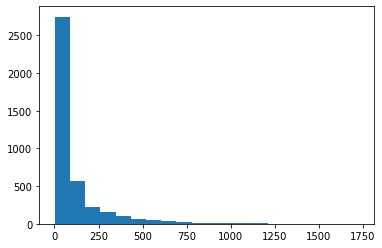

Histograma para la columna: rt_15


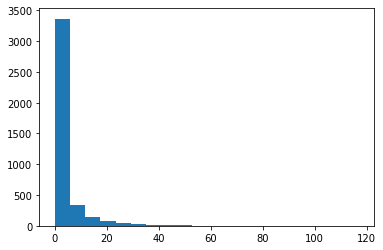

Histograma para la columna: aprobt_15


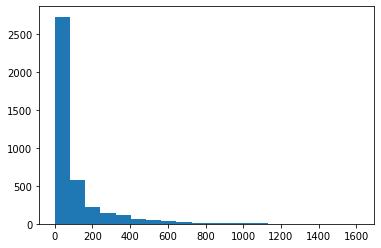

Histograma para la columna: reprot_15


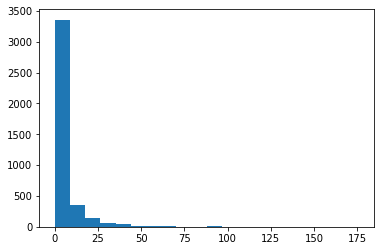

Histograma para la columna: desa_15


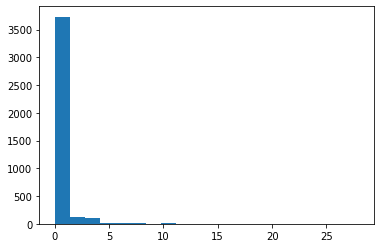

Histograma para la columna: desert_15


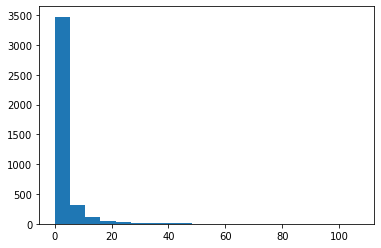

Histograma para la columna: act_15


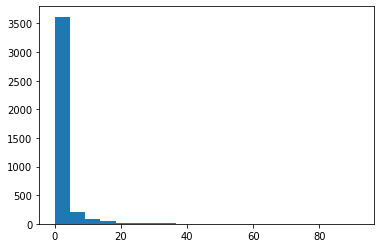

Histograma para la columna: nst_15


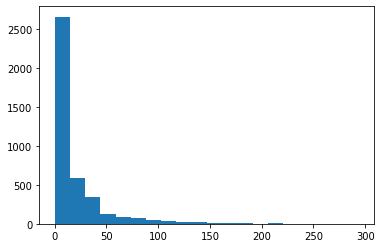

Histograma para la columna: sit_15


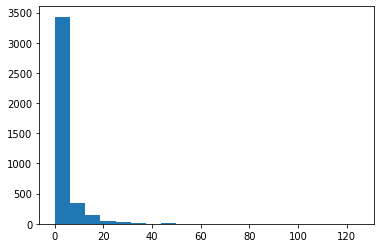

Histograma para la columna: embt_15


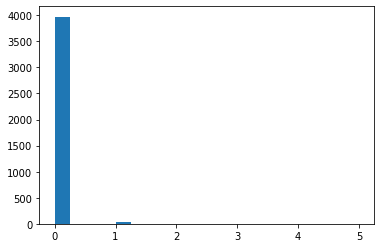

Histograma para la columna: embmenor_15


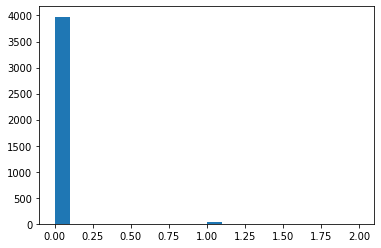

Histograma para la columna: embmayor_15


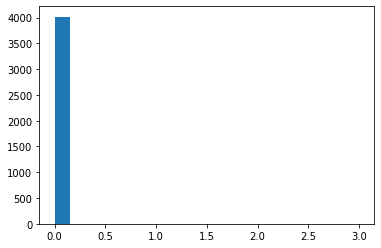

Histograma para la columna: aat15


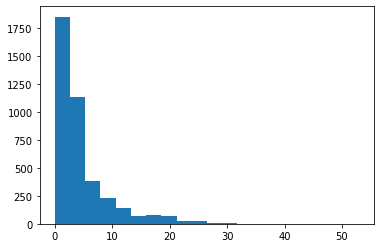

Histograma para la columna: inft15


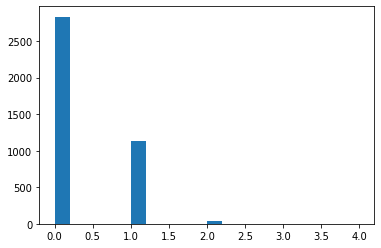

Histograma para la columna: olat15


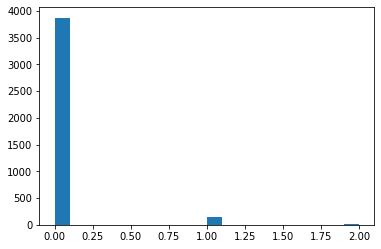

Histograma para la columna: salt15


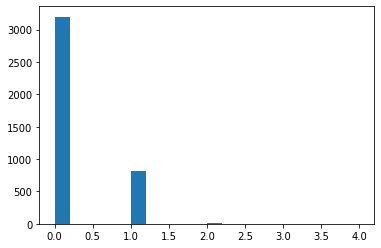

Histograma para la columna: comt15


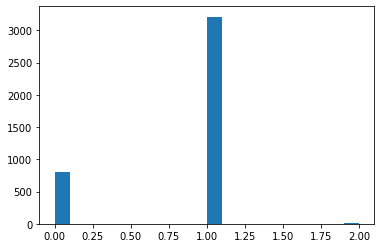

Histograma para la columna: bibt15


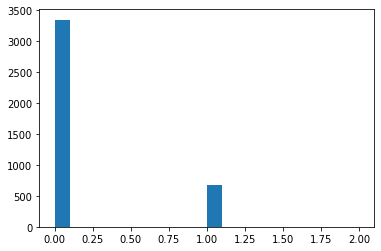

Histograma para la columna: gimt15


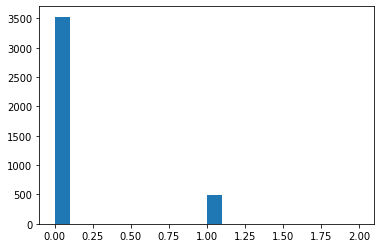

Histograma para la columna: talt_ai15


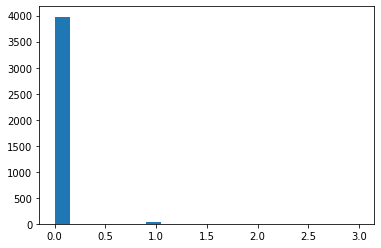

Histograma para la columna: otalt15


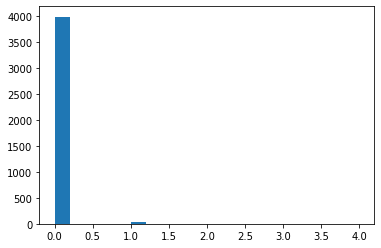

Histograma para la columna: sodt15


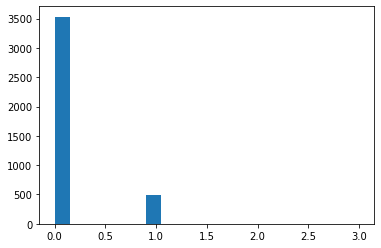

Histograma para la columna: indt15


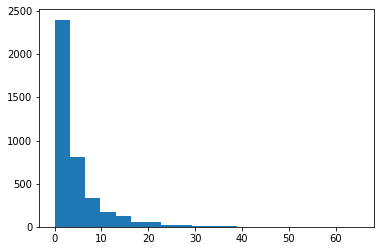

Histograma para la columna: lavt15


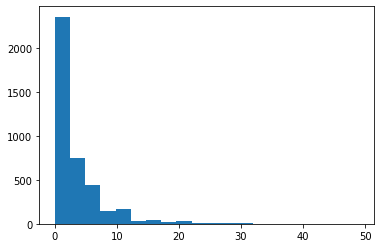

Histograma para la columna: sant15


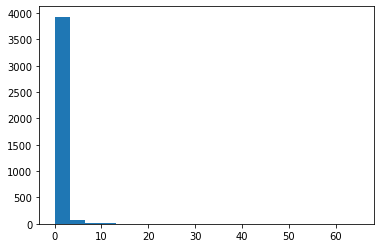

Histograma para la columna: tvt15


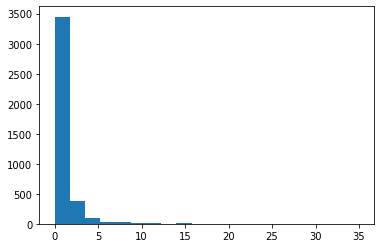

Histograma para la columna: vbt15


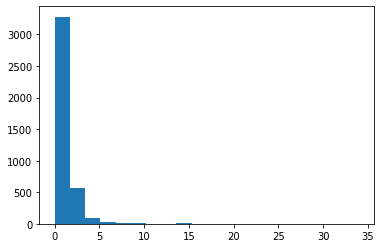

Histograma para la columna: dvdt15


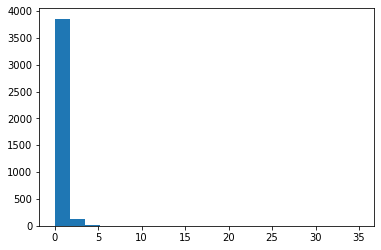

Histograma para la columna: cetoi15


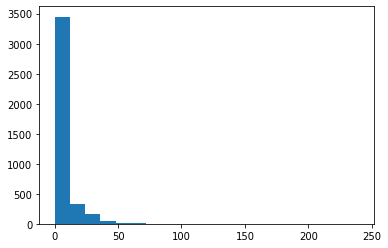

Histograma para la columna: cetos15


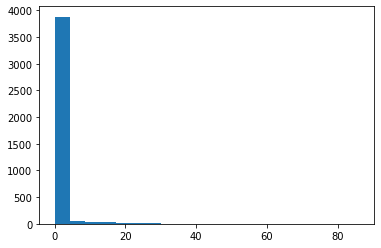

Histograma para la columna: cptoi15


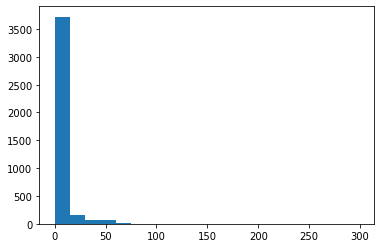

Histograma para la columna: cptos15


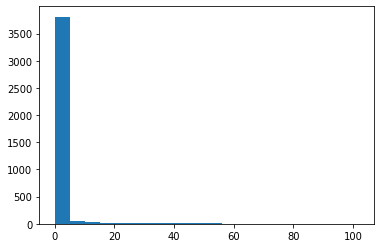

Histograma para la columna: expto_15


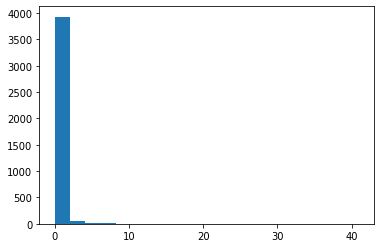

Histograma para la columna: expdef_15


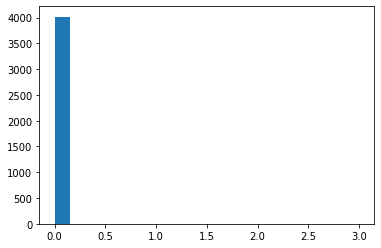

Histograma para la columna: exptem_15


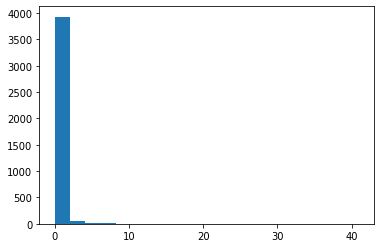

Histograma para la columna: agrve_15


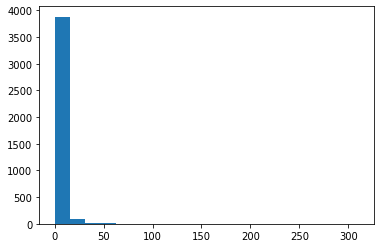

Histograma para la columna: agrvep_15


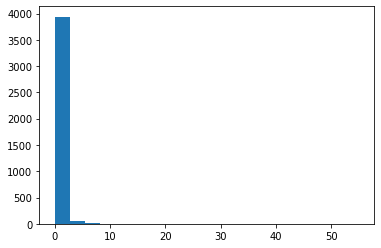

Histograma para la columna: agrveo_15


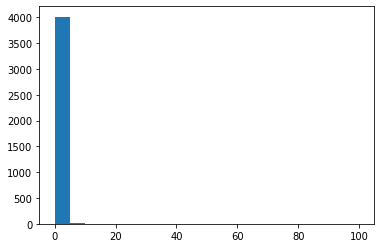

Histograma para la columna: agrfe_15


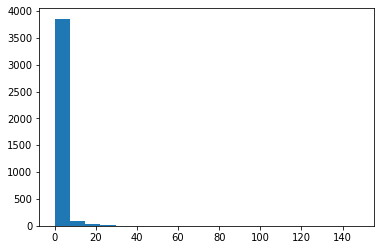

Histograma para la columna: agrfep_15


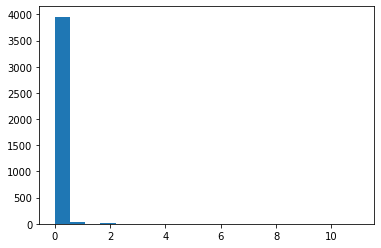

Histograma para la columna: agrfeo_15


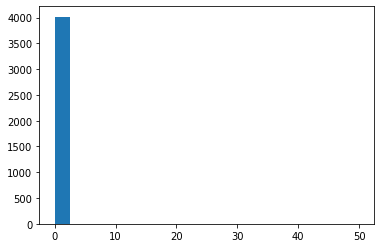

Histograma para la columna: agree_15


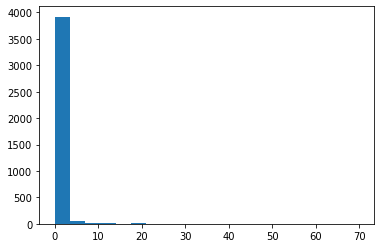

Histograma para la columna: agreep_15


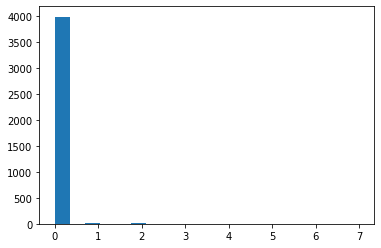

Histograma para la columna: agreeo_15


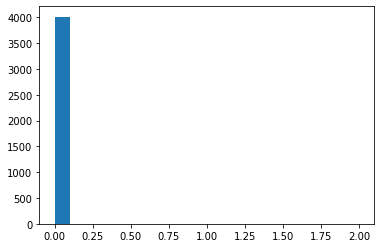

Histograma para la columna: agrre_15


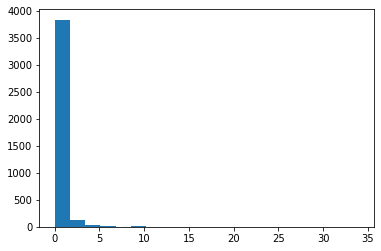

Histograma para la columna: agrrep_15


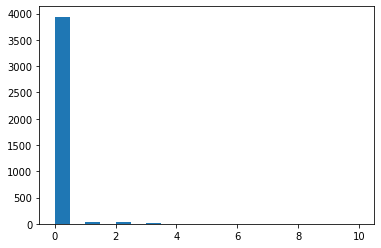

Histograma para la columna: agrreo_15


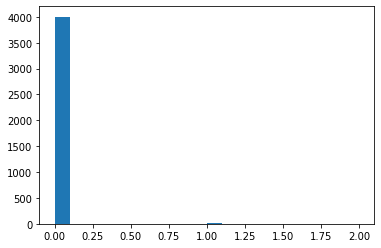

Histograma para la columna: agrde_15


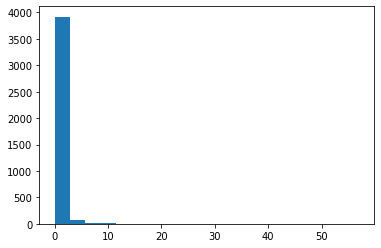

Histograma para la columna: agrdep_15


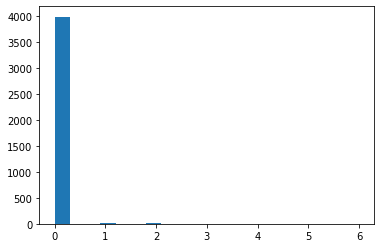

Histograma para la columna: agrdeo_15


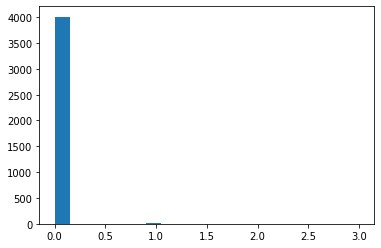

Histograma para la columna: agroe_15


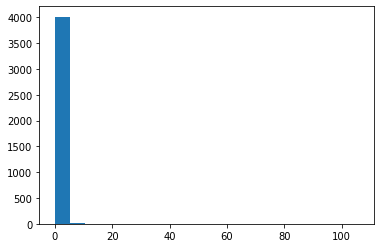

Histograma para la columna: agroep_15


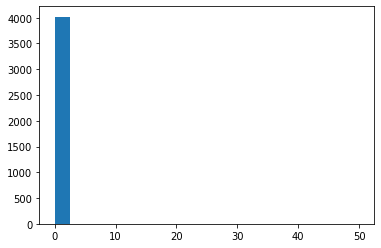

Histograma para la columna: agroeo_15


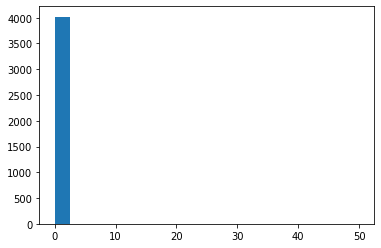

Histograma para la columna: int_15


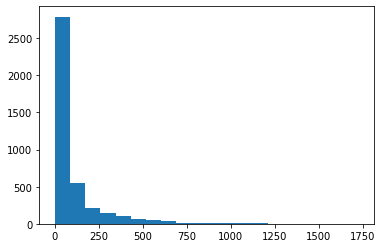

Histograma para la columna: rit_15


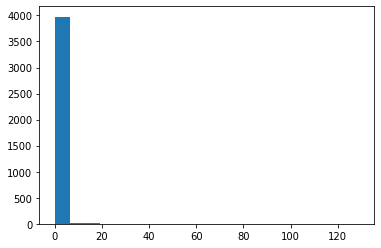

Histograma para la columna: frt_15


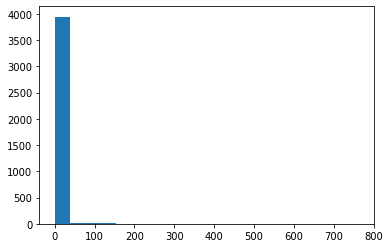

Histograma para la columna: itt_15


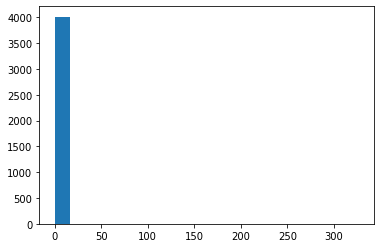

Histograma para la columna: extrant_15


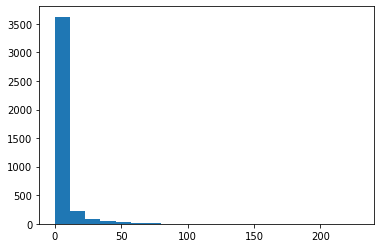

Histograma para la columna: PromocionAlta


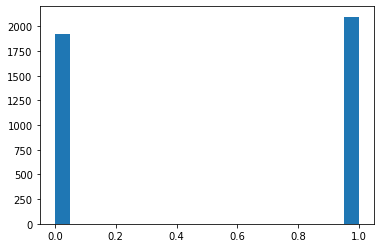

Histograma para la columna: Dimension_Economica


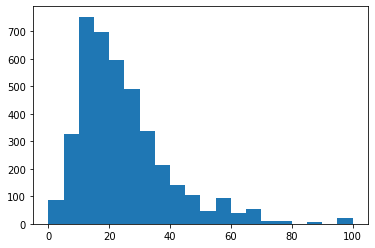

Histograma para la columna: Dimension_Participacion


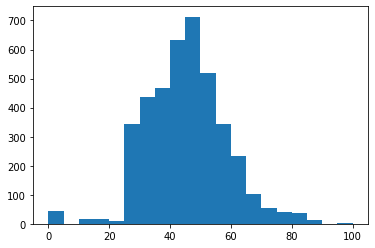

Histograma para la columna: Dimension_Salud


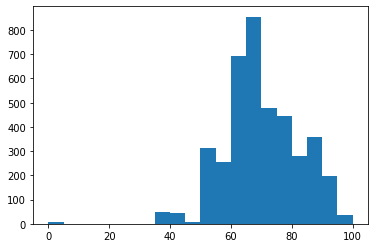

Histograma para la columna: Dimension_Educativa


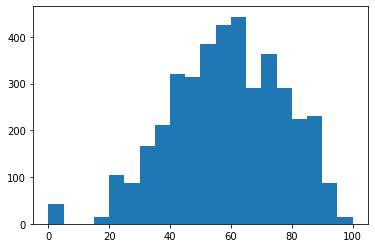

Histograma para la columna: IDS


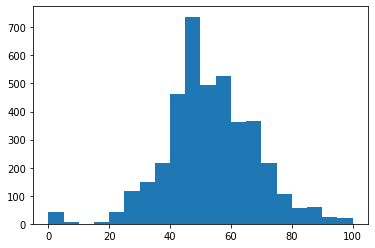

In [129]:
import matplotlib.pyplot as plt

# Genera un histograma para cada una de las columnas del dataframe
def HistogramaColumnas(columns, df):
    for col in columns:
        print("Histograma para la columna:", col)
        bins, counts = df.select(col).rdd.flatMap(lambda x: x).histogram(20)
        plt.hist(bins[:-1], bins=bins, weights=counts)
        plt.show()
    
HistogramaColumnas(columns_kept, selected_columns_df)  

## Correlaciones

+--------------------+-------------+
|            features|PromocionAlta|
+--------------------+-------------+
|(63,[0,2,3,7,8,12...|            1|
|(63,[0,2,6,7,12,1...|            1|
|(63,[0,1,2,3,5,6,...|            0|
|(63,[0,2,5,12,13,...|            1|
|(63,[0,1,2,3,5,7,...|            1|
|(63,[0,1,2,3,5,7,...|            0|
|(63,[0,1,2,3,6,7,...|            0|
|(63,[0,1,2,3,4,6,...|            1|
|(63,[0,1,2,3,6,7,...|            0|
|(63,[0,1,2,3,5,6,...|            1|
|(63,[0,1,2,3,5,6,...|            1|
|(63,[0,1,2,3,5,6,...|            0|
|(63,[0,1,2,3,4,5,...|            1|
|(63,[0,1,2,3,7,8,...|            1|
|(63,[0,2,7,12,13,...|            1|
|(63,[0,1,2,3,4,5,...|            0|
|(63,[0,1,2,3,7,8,...|            1|
|(63,[0,1,2,3,4,6,...|            0|
|(63,[0,1,2,3,5,7,...|            0|
|(63,[0,1,2,3,5,7,...|            1|
+--------------------+-------------+
only showing top 20 rows

Matriz de correlación de Pearson:


<AxesSubplot:>

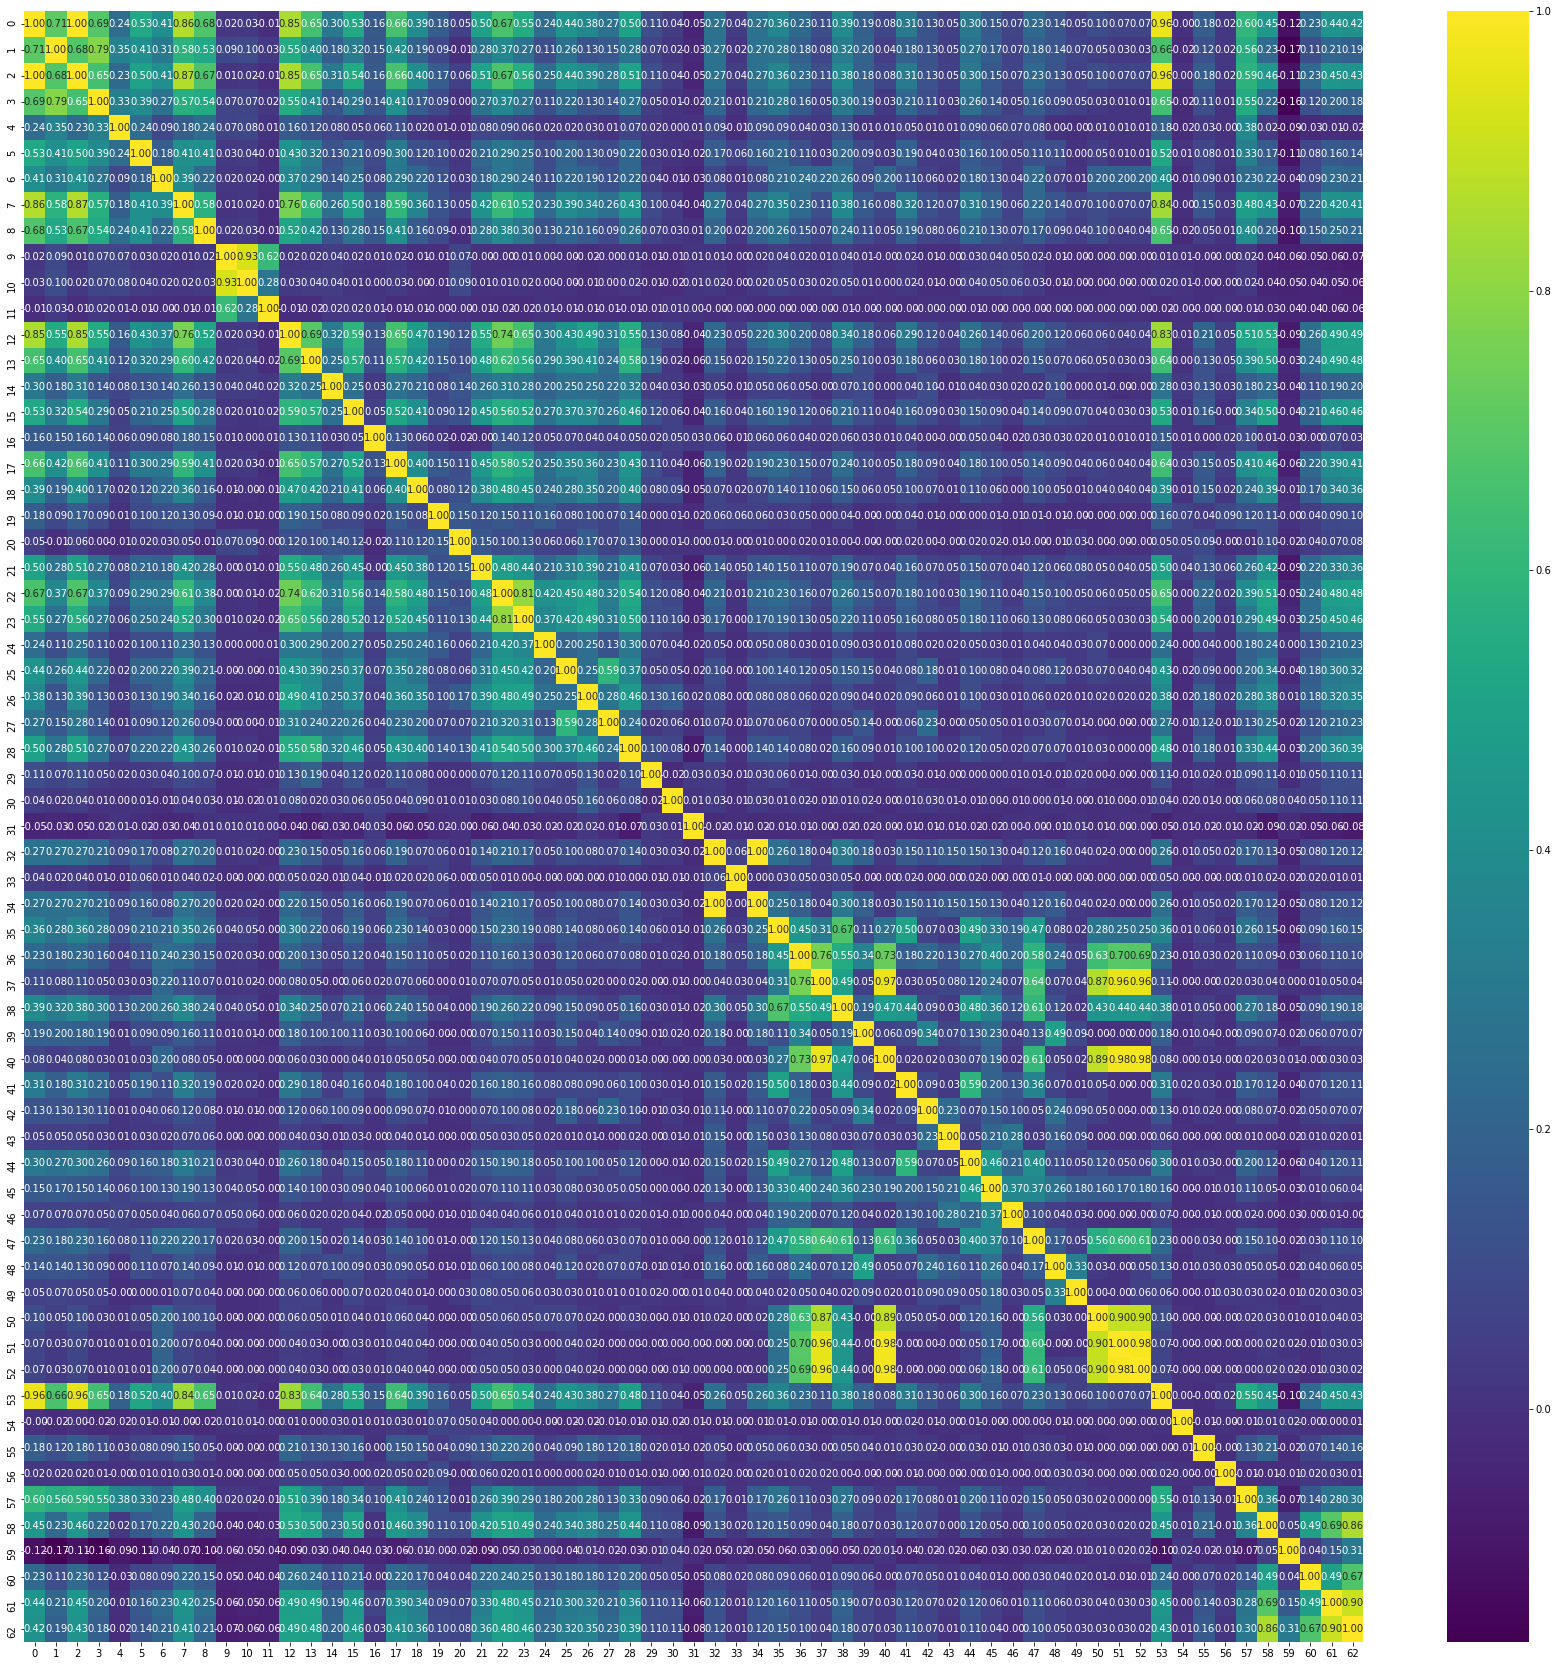

In [130]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['mit_15', 'rt_15', 'aprobt_15', 'reprot_15', 'desa_15', 'desert_15', 'act_15', 'nst_15', 'sit_15', 
    'embt_15', 'embmenor_15', 'embmayor_15', 'aat15', 'inft15', 'olat15', 'salt15', 'comt15', 'bibt15', 'gimt15', 
    'talt_ai15', 'otalt15', 'sodt15', 'indt15', 'lavt15', 'sant15', 'tvt15', 'vbt15', 'dvdt15', 'cetoi15', 'cetos15', 
    'cptoi15', 'cptos15', 'expto_15', 'expdef_15', 'exptem_15', 'agrve_15', 'agrvep_15', 'agrveo_15', 'agrfe_15', 'agrfep_15', 
    'agrfeo_15', 'agree_15', 'agreep_15', 'agreeo_15', 'agrre_15', 'agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 
    'agrdeo_15', 'agroe_15', 'agroep_15', 'agroeo_15', 'int_15', 'rit_15', 'frt_15', 'itt_15', 'extrant_15', 
    'Dimension_Economica', 'Dimension_Participacion', 'Dimension_Salud','Dimension_Educativa', 'IDS'],
    outputCol='features')     

vector_df = assembler.transform(selected_columns_df)
vector_df = vector_df.select(['features', 'PromocionAlta'])
vector_df.show()

# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,30))

# Genera la matriz de correlación de Pearson
pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]
print("Matriz de correlación de Pearson:")
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')




### Análisis de matriz de correlación.

Basado en los resultados de la matriz de correlación de Pearson anterior, se concluye que las siguientes columnas tienen alta correlación entre sí:

* 'mit_15' con 'aprobt_15' (0 con 2): en este caso se escogerá 'mit_15' para que continúe en el ejercicio.
* 'embt_15' con 'embmenor_15' (9 con 10): en este caso se escogerá 'embt_15' para que continúe en el ejercicio.
* 'expto_15' con 'exptem_15' (32 con 34): en este caso se escogerá 'expto_15' para que continúe en el ejercicio.
* 'agroe_15' con 'agroep_15' (50 con 51): en este caso se escogerá 'agroe_15' para que continúe en el ejercicio.
* 'agroe_15' con 'agroeo_15' (50 con 52): en este caso se escogerá 'agroe_15' para que continúe en el ejercicio.
* 'agroep_15' con 'agroeo_15' (51 con 52): ambas se eliminan producto de los 2 puntos anteriores.
* 'Dimension_Educativa' con 'IDS' (61 con 62): en este caso se escogerá 'Dimension_Educativa' para que continúe en el ejercicio.
* 'int_15' con 'mit_15' (53 con 0): en este caso se escogerá 'mit_15' para que continúe en el ejercicio.
* 'int_15' con 'aprobt_15' (53 con 2): ambas se eliminan producto de los puntos anteriores.
* 'agroep_15' con 'agrveo_15' (51 con 37): en este caso se escogerá 'agrveo_15' para que continúe en el ejercicio.
* 'agroeo_15' con 'agrveo_15' (52 con 37): en este caso se escogerá 'agrveo_15' para que continúe en el ejercicio.
* 'agroep_15' con 'agrfeo_15' (51 con 40): en este caso se escogerá 'agrfeo_15' para que continúe en el ejercicio.
* 'agroeo_15' con 'agrfeo_15' (52 con 40): en este caso se escogerá 'agrfeo_15' para que continúe en el ejercicio.

#### Se genera nuevamente la matriz de correlación de Pearson, quitando columnas altamente correlacionadas: 

+--------------------+-------------+
|            features|PromocionAlta|
+--------------------+-------------+
|(55,[0,2,6,7,10,1...|            1|
|(55,[0,5,6,10,11,...|            1|
|(55,[0,1,2,4,5,6,...|            0|
|(55,[0,4,10,11,13...|            1|
|(55,[0,1,2,4,6,7,...|            1|
|(55,[0,1,2,4,6,7,...|            0|
|(55,[0,1,2,5,6,7,...|            0|
|(55,[0,1,2,3,5,6,...|            1|
|(55,[0,1,2,5,6,7,...|            0|
|(55,[0,1,2,4,5,6,...|            1|
|(55,[0,1,2,4,5,6,...|            1|
|(55,[0,1,2,4,5,6,...|            0|
|(55,[0,1,2,3,4,5,...|            1|
|(55,[0,1,2,6,7,10...|            1|
|(55,[0,6,10,11,13...|            1|
|(55,[0,1,2,3,4,5,...|            0|
|(55,[0,1,2,6,7,10...|            1|
|(55,[0,1,2,3,5,6,...|            0|
|(55,[0,1,2,4,6,10...|            0|
|(55,[0,1,2,4,6,7,...|            1|
+--------------------+-------------+
only showing top 20 rows

Matriz de correlación de Pearson:


<AxesSubplot:>

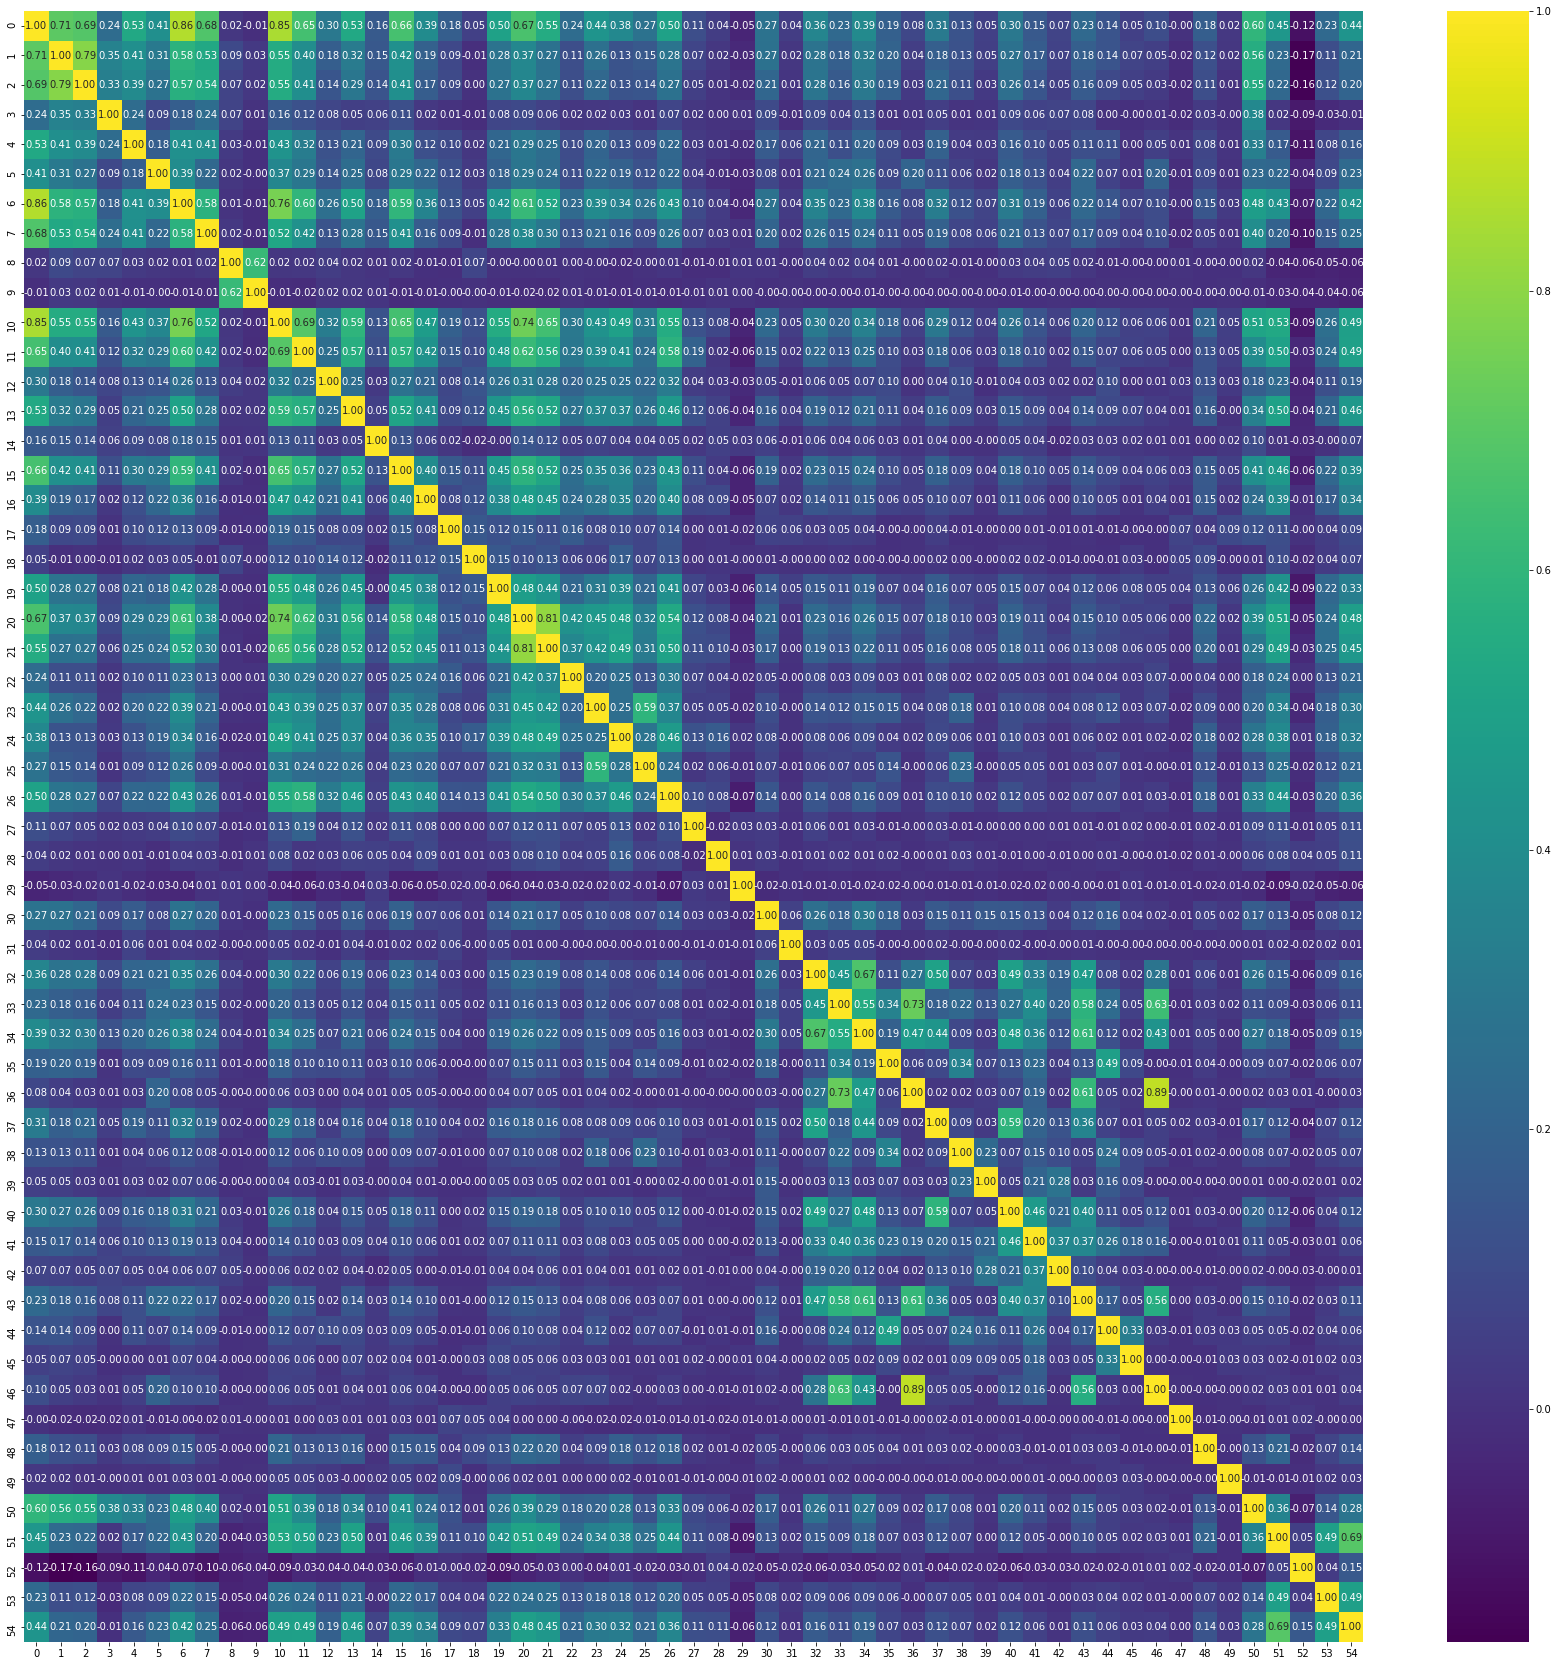

In [131]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler
  
assembler = VectorAssembler(
    inputCols=['mit_15', 'rt_15', 'reprot_15', 'desa_15', 'desert_15', 'act_15', 'nst_15', 'sit_15', 
    'embt_15', 'embmayor_15', 'aat15', 'inft15', 'olat15',  
    'salt15', 'comt15', 'bibt15', 'gimt15', 'talt_ai15', 'otalt15', 'sodt15', 'indt15', 'lavt15', 
    'sant15', 'tvt15', 'vbt15', 'dvdt15', 'cetoi15', 'cetos15', 'cptoi15', 'cptos15', 
    'expto_15', 'expdef_15', 'agrve_15', 'agrvep_15', 'agrfe_15', 'agrfep_15', 'agrfeo_15', 'agree_15', 
    'agreep_15', 'agreeo_15', 'agrre_15', 'agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 'agrdeo_15', 'agroe_15', 'rit_15', 'frt_15', 
    'itt_15', 'extrant_15', 'Dimension_Economica', 'Dimension_Participacion', 'Dimension_Salud','Dimension_Educativa'],
    outputCol='features')  

vector_df = assembler.transform(selected_columns_df)
vector_df = vector_df.select(['features', 'PromocionAlta'])
vector_df.show()

# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,30))

# Genera la matriz de correlación de Pearson
pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]
print("Matriz de correlación de Pearson:")
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')




#### Elimina de selected_columns_df, las columnas que se quitaron anteriormente, producto del análisis de la matriz de correlación

In [132]:
selected_columns_df = selected_columns_df \
    .drop('aprobt_15') \
    .drop('embmenor_15') \
    .drop('exptem_15') \
    .drop('agroep_15') \
    .drop('agroeo_15') \
    .drop('IDS') \
    .drop('int_15') \
    .drop('agrveo_15') \

selected_columns_df.show()

+------+-----+---------+-------+---------+------+------+------+-------+-----------+-----+------+------+------+------+------+------+---------+-------+------+------+------+------+-----+-----+------+-------+-------+-------+-------+--------+---------+--------+---------+--------+---------+---------+--------+---------+---------+--------+---------+---------+--------+---------+---------+--------+------+------+------+----------+-------------+-------------------+-----------------------+---------------+-------------------+
|mit_15|rt_15|reprot_15|desa_15|desert_15|act_15|nst_15|sit_15|embt_15|embmayor_15|aat15|inft15|olat15|salt15|comt15|bibt15|gimt15|talt_ai15|otalt15|sodt15|indt15|lavt15|sant15|tvt15|vbt15|dvdt15|cetoi15|cetos15|cptoi15|cptos15|expto_15|expdef_15|agrve_15|agrvep_15|agrfe_15|agrfep_15|agrfeo_15|agree_15|agreep_15|agreeo_15|agrre_15|agrrep_15|agrreo_15|agrde_15|agrdep_15|agrdeo_15|agroe_15|rit_15|frt_15|itt_15|extrant_15|PromocionAlta|Dimension_Economica|Dimension_Participacion|D

## Normalización / Estandarización

In [133]:
# Es deseable que los datos se encuentren estandarizados o normalizados, para evitar que la magnitud de ciertos atributos 
# dominen el proceso de entrenamiento. El módulo pyspark.ml.feature tiene varias alternativas. En este caso se usa StandardScaler.
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
print("Datos estandarizados:")
scaled_df.show()

# Agregar columna features al dataframe
selected_columns_df = assembler.transform(selected_columns_df)
# Agregar columna scaled al dataframe df
selected_columns_df = scale_model.transform(selected_columns_df)



Datos estandarizados:
+--------------------+-------------+--------------------+
|            features|PromocionAlta|              scaled|
+--------------------+-------------+--------------------+
|(55,[0,2,6,7,10,1...|            1|(55,[0,2,6,7,10,1...|
|(55,[0,5,6,10,11,...|            1|(55,[0,5,6,10,11,...|
|(55,[0,1,2,4,5,6,...|            0|(55,[0,1,2,4,5,6,...|
|(55,[0,4,10,11,13...|            1|(55,[0,4,10,11,13...|
|(55,[0,1,2,4,6,7,...|            1|(55,[0,1,2,4,6,7,...|
|(55,[0,1,2,4,6,7,...|            0|(55,[0,1,2,4,6,7,...|
|(55,[0,1,2,5,6,7,...|            0|(55,[0,1,2,5,6,7,...|
|(55,[0,1,2,3,5,6,...|            1|(55,[0,1,2,3,5,6,...|
|(55,[0,1,2,5,6,7,...|            0|(55,[0,1,2,5,6,7,...|
|(55,[0,1,2,4,5,6,...|            1|(55,[0,1,2,4,5,6,...|
|(55,[0,1,2,4,5,6,...|            1|(55,[0,1,2,4,5,6,...|
|(55,[0,1,2,4,5,6,...|            0|(55,[0,1,2,4,5,6,...|
|(55,[0,1,2,3,4,5,...|            1|(55,[0,1,2,3,4,5,...|
|(55,[0,1,2,6,7,10...|            1|(55,[0,1,2,6,7

# Entrenamiento de modelos

## Dividir los datos en 2 conjuntos (para entrenamiento y prueba)

In [135]:
# Genera un dataframe nuevo con una columna "features" (a partir de los datos estandarizados de columna scaled) 
# y otra columna "label" (a partir de "PromocionAlta")
df_new = selected_columns_df.select('mit_15', 'rt_15', 'reprot_15', 'desa_15', 'desert_15', 'act_15', 'nst_15', 'sit_15', 
    'embt_15', 'embmayor_15', 'aat15', 'inft15', 'olat15', 'salt15', 'comt15', 'bibt15', 'gimt15', 'talt_ai15', 'otalt15', 
    'sodt15', 'indt15', 'lavt15', 'sant15', 'tvt15', 'vbt15', 'dvdt15', 'cetoi15', 'cetos15', 'cptoi15', 'cptos15', 
    'expto_15', 'expdef_15', 'agrve_15', 'agrvep_15', 'agrfe_15', 'agrfep_15', 'agrfeo_15', 'agree_15', 'agreep_15', 
    'agreeo_15', 'agrre_15', 'agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 'agrdeo_15', 'agroe_15', 'rit_15', 'frt_15', 
    'itt_15', 'extrant_15', 'PromocionAlta', 'Dimension_Economica', 'Dimension_Participacion', 'Dimension_Salud',
    'Dimension_Educativa', col("scaled").alias("features"), col("PromocionAlta").alias("label"))


# Separa los datos del dataframe en dos nuevos datasets para entrenamiento y prueba 
# 80% para entrenamiento (train) y 20% para prueba (test)
train, test = df_new.randomSplit([0.8, 0.2], seed=12345)

print ("Los datos del dataframe fueron separados en dos nuevos datasets para entrenamiento y prueba, 80% para entrenamiento (train) y 20% para prueba (test)")

Los datos del dataframe fueron separados en dos nuevos datasets para entrenamiento y prueba, 80% para entrenamiento (train) y 20% para prueba (test)


## Modelo 1: Regresión Logística
## Uso de protocolo K-fold cross validation y Entrenamiento del modelo


In [136]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Aplica el protocolo K-fold cross validation para el modelo de regresión logística
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lr_evaluator = BinaryClassificationEvaluator()

lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])
             .addGrid(lr.maxIter, [10, 20])
             .build())

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=lr_evaluator, numFolds=5)

# Realiza el entrenamiento del modelo
lr_cv_model = lr_cv.fit(train)

trainingSummary = lr_cv_model.bestModel.summary

# Muestra métricas sobre el conjunto de datos de entrenamiento
print("------------------------------------------------------------------------------")
print("ENTRENAMIENTO: Métricas del mejor modelo obtenido con K-fold Cross Validation")
print("------------------------------------------------------------------------------")
print(" - Total de Iteraciones:", trainingSummary.totalIterations)
print(" - Historial de Cada Iteración:", trainingSummary.objectiveHistory)
print(" - Exactitud:", trainingSummary.accuracy)
print(" - Area bajo la curva ROC:", trainingSummary.areaUnderROC)



------------------------------------------------------------------------------
ENTRENAMIENTO: Métricas del mejor modelo obtenido con K-fold Cross Validation
------------------------------------------------------------------------------
 - Total de Iteraciones: 20
 - Historial de Cada Iteración: [0.6919237495808931, 0.6542620840927692, 0.6058638180801061, 0.5808192039812734, 0.5613564405281624, 0.5338053831714995, 0.5041928629511451, 0.4868798364514966, 0.47088483463874603, 0.4654391440244393, 0.4640680403436124, 0.46302625361697325, 0.46252910375748946, 0.4621433189797213, 0.4617543775148462, 0.4616837840716408, 0.4613778371083128, 0.4612659473064972, 0.4609661774593637, 0.46088503682404847, 0.46072289835962216]
 - Exactitud: 0.8541213063763609
 - Area bajo la curva ROC: 0.9485758045044164


## Modelo 2: Random Forest
## Uso de protocolo K-fold cross validation y Entrenamiento del modelo

In [137]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

# Aplica el protocolo K-fold cross validation para el modelo de random forest
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_evaluator = BinaryClassificationEvaluator()

rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [3, 10])
             .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=rf_evaluator, numFolds=5)

# Realiza el entrenamiento del modelo
rf_cv_model = rf_cv.fit(train)

trainingSummary = rf_cv_model.bestModel.summary

# Muestra métricas sobre el conjunto de datos de entrenamiento
print("------------------------------------------------------------------------------")
print("ENTRENAMIENTO: Métricas del mejor modelo obtenido con K-fold Cross Validation")
print("------------------------------------------------------------------------------")
print(" - Exactitud:", trainingSummary.accuracy)
print(" - Area bajo la curva ROC:", trainingSummary.areaUnderROC)



------------------------------------------------------------------------------
ENTRENAMIENTO: Métricas del mejor modelo obtenido con K-fold Cross Validation
------------------------------------------------------------------------------
 - Exactitud: 0.8824261275272162
 - Area bajo la curva ROC: 0.9514812610756093


# Evaluación de conjunto de validación

## Evaluación y almacenado de modelo 1

In [138]:
#Predicción del modelo
predictions = lr_cv_model.transform(test)

print("Datos de predicción del modelo 1:")
predictions.select('features','PromocionAlta', 'prediction').show()

# Evaluación del modelo, usando la métrica de "área bajo la curva ROC (areaUnderROC)"
evaluator_modelo1 = lr_evaluator.evaluate(predictions,{lr_evaluator.metricName: "areaUnderROC"})

print("------------------------------------------------------------------------------")
print("EVALUACIÓN: Métrica del modelo 1:")
print("------------------------------------------------------------------------------")
print(" - Área bajo la curva ROC:", evaluator_modelo1)

# Almacenar los datos de la predicción en la base de datos, a una tabla llamada "modelo1" (con overwrite) 
predictions.select('mit_15', 'rt_15', 'reprot_15', 'desa_15', 'desert_15', 'act_15', 'nst_15', 'sit_15', 
    'embt_15', 'embmayor_15', 'aat15', 'inft15', 'olat15', 'salt15', 'comt15', 'bibt15', 'gimt15', 'talt_ai15', 
    'otalt15', 'sodt15', 'indt15', 'lavt15', 'sant15', 'tvt15', 'vbt15', 'dvdt15', 'cetoi15', 'cetos15', 'cptoi15', 
    'cptos15', 'expto_15', 'expdef_15', 'agrve_15', 'agrvep_15', 'agrfe_15', 'agrfep_15', 'agrfeo_15', 'agree_15', 
    'agreep_15', 'agreeo_15', 'agrre_15', 'agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 'agrdeo_15', 'agroe_15', 
    'rit_15', 'frt_15', 'itt_15', 'extrant_15', 'PromocionAlta', 'Dimension_Economica', 'Dimension_Participacion', 
    'Dimension_Salud','Dimension_Educativa', col("prediction").alias("prediccion")) \
    .write \
    .mode("overwrite") \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

print("\n\n Los datos de predicción fueron almacenados exitosamente en base de datos, en la tabla 'modelo1'.")
      


Datos de predicción del modelo 1:
+--------------------+-------------+----------+
|            features|PromocionAlta|prediction|
+--------------------+-------------+----------+
|(55,[0,10,14,20,2...|            1|       1.0|
|(55,[0,10,14,51,5...|            1|       1.0|
|(55,[0,10,14,24,2...|            1|       1.0|
|(55,[0,10,14,20,5...|            1|       1.0|
|(55,[0,10,14,20,2...|            1|       1.0|
|(55,[0,10,14,20,2...|            1|       1.0|
|(55,[0,10,11,20,2...|            1|       1.0|
|(55,[0,1,6,10,14,...|            1|       1.0|
|(55,[0,7,10,14,29...|            1|       1.0|
|(55,[0,6,10,14,20...|            1|       1.0|
|(55,[0,6,10,14,20...|            1|       1.0|
|(55,[0,4,10,14,22...|            0|       0.0|
|(55,[0,2,4,10,51,...|            0|       0.0|
|(55,[0,1,6,10,14,...|            1|       1.0|
|(55,[0,10,51,52,5...|            1|       1.0|
|(55,[0,10,29,51,5...|            1|       1.0|
|(55,[0,10,20,21,5...|            1|       1.0|
|(55,[

## Evaluación y almacenado de modelo 2

In [141]:
#Predicción del modelo
predictions = rf_cv_model.transform(test)

print("Datos de predicción del modelo 2:")
predictions.select('features','PromocionAlta', 'prediction').show()

# Evaluación del modelo, usando la métrica de "área bajo la curva ROC (areaUnderROC)"
evaluator_modelo2 = rf_evaluator.evaluate(predictions,{lr_evaluator.metricName: "areaUnderROC"})

print("------------------------------------------------------------------------------")
print("EVALUACIÓN: Métrica del modelo 2:")
print("------------------------------------------------------------------------------")
print(" - Área bajo la curva ROC:", evaluator_modelo2)

# Almacenar los datos de la predicción en la base de datos, a una tabla llamada "modelo2" (con overwrite)
predictions.select('mit_15', 'rt_15', 'reprot_15', 'desa_15', 'desert_15', 'act_15', 'nst_15', 'sit_15', 
    'embt_15', 'embmayor_15', 'aat15', 'inft15', 'olat15',  
    'salt15', 'comt15', 'bibt15', 'gimt15', 'talt_ai15', 'otalt15', 'sodt15', 'indt15', 'lavt15', 
    'sant15', 'tvt15', 'vbt15', 'dvdt15', 'cetoi15', 'cetos15', 'cptoi15', 'cptos15', 
    'expto_15', 'expdef_15', 'agrve_15', 'agrvep_15', 'agrfe_15', 'agrfep_15', 'agrfeo_15', 'agree_15', 
    'agreep_15', 'agreeo_15', 'agrre_15', 'agrrep_15', 'agrreo_15', 'agrde_15', 'agrdep_15', 'agrdeo_15', 'agroe_15', 'rit_15', 'frt_15', 
    'itt_15', 'extrant_15', 'PromocionAlta', 'Dimension_Economica', 'Dimension_Participacion', 'Dimension_Salud','Dimension_Educativa', col("prediction").alias("prediccion")) \
    .write \
    .mode("overwrite") \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()

print("\n\n Los datos de predicción fueron almacenados exitosamente en base de datos, en la tabla 'modelo2'.")



Datos de predicción del modelo 2:
+--------------------+-------------+----------+
|            features|PromocionAlta|prediction|
+--------------------+-------------+----------+
|(55,[0,10,14,20,2...|            1|       1.0|
|(55,[0,10,14,51,5...|            1|       1.0|
|(55,[0,10,14,24,2...|            1|       1.0|
|(55,[0,10,14,20,5...|            1|       1.0|
|(55,[0,10,14,20,2...|            1|       1.0|
|(55,[0,10,14,20,2...|            1|       1.0|
|(55,[0,10,11,20,2...|            1|       1.0|
|(55,[0,1,6,10,14,...|            1|       1.0|
|(55,[0,7,10,14,29...|            1|       1.0|
|(55,[0,6,10,14,20...|            1|       1.0|
|(55,[0,6,10,14,20...|            1|       1.0|
|(55,[0,4,10,14,22...|            0|       0.0|
|(55,[0,2,4,10,51,...|            0|       0.0|
|(55,[0,1,6,10,14,...|            1|       1.0|
|(55,[0,10,51,52,5...|            1|       1.0|
|(55,[0,10,29,51,5...|            1|       1.0|
|(55,[0,10,20,21,5...|            1|       1.0|
|(55,[

## Análisis de resultados

#### Introducción Teórica 

La medición del rendimiento es una tarea esencial. Por lo tanto, cuando se trata de un problema de clasificación, podemos contar con una curva AUC-ROC. Esta es una de las métricas de evaluación más importante para verificar el rendimiento de cualquier modelo de clasificación.

ROC viene de las características de funcionamiento del receptor y AUC del área bajo la curva.

La curva ROC nos dice qué tan bueno puede distinguir el modelo entre dos cosas.

El AUC es el área bajo la curva ROC. Este puntaje nos da una buena idea de qué tan bien funciona el modelo.

El AUC proporciona una medición agregada del rendimiento en todos los umbrales de clasificación posibles. Una forma de interpretar el AUC es como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.

El AUC oscila en valor del 0 al 1. Un modelo cuyas predicciones son un 100% incorrectas tiene un AUC de 0.0; otro cuyas predicciones son un 100% correctas tiene un AUC de 1.0.

El AUC es conveniente por las dos razones siguientes:

- El AUC es invariable con respecto a la escala. Mide qué tan bien se clasifican las predicciones, en lugar de sus valores absolutos.
- El AUC es invariable con respecto al umbral de clasificación. Mide la calidad de las predicciones del modelo, sin tener en cuenta qué umbral de clasificación se elige.

Fuente: https://aprendeia.com/curvas-roc-y-area-bajo-la-curva-auc-machine-learning/


#### Análisis y conclusiones

Para el análisis de resultados se utilizó la métrica del "área bajo la curva ROC (AUC)" obtenida tanto para el modelo 1: Regresión Logística, como para el modelo 2: Random Forest, para medir el rendimiento de cada modelo y hacer la comparación entre ambos. 

Como se puede observar en la sección anterior de evaluación de modelo 1, específicamente en la parte dónde se indica "EVALUACIÓN: Métrica del modelo 1" el modelo de Regresión Logística muestra un área bajo la curva ROC de 0.93, lo que significa que hay 93% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa.

Para el caso del modelo Random Forest, en la sección anterior de evaluación de modelo 2, específicamente en la parte dónde se indica "EVALUACIÓN: Métrica del modelo 2" se muestra un área bajo la curva ROC de 0.92, lo que significa que hay 92% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa.

Se observa que tanto el modelo1 como el modelo2 elegidos logran obtener para AUC valores bastante aceptables. Para efectos didácticos se obtienen mucho mejores resultados que los obtenidos en la tarea 3, dado que para este proyecto se cuenta con una mayor cantidad de registros para el entrenamiento y prueba de los modelos. Además se realizó un análisis mucho más profundo de correlación de features antes de predecir, lo cual ayudó a depurar de manera más adecuada las columnas elegidas para la predicción de "Promoción Alta".

Realizando la comparación entre ambos modelos, basado en el "área bajo la curva ROC (AUC)", el modelo 1 de Regresión Logística obtiene mejores resultados, dado que presenta un valor más alto. Este rendimiendo superior que obtiene el modelo 1 también se puede observar en los datos de predicción de ambos modelos, almacenados en base de datos, en las tablas "modelo1" y "modelo2", donde se muestra que el modelo 1 de Regresión Logística presenta mayor cantidad de predicciones correctas. 

